In [105]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.applications import VGG16
from keras.regularizers import l2
from matplotlib import pyplot as plt
import keras.callbacks
import cv2
import xml.etree.ElementTree as ET

In [106]:
# SET GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [107]:
SEED = 123
N_CLASSES = 8
IMG_SIZE = 300
BUFFER_SIZE = 1000
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

L2_REG = 0.0005


In [108]:
# X_data_final = np.load("data/X_data_final.npy")
# labels_final = np.load("data/labels_final.npy", allow_pickle=True)
# with open("data/obj.names", "r") as f:
#     classes = f.read().splitlines()

-0.05755278338181266 -0.1282634615004674 0.08386857285549687 0.1545792509741516
-0.0868421052631579 -0.0868421052631579 0.11315789473684211 0.11315789473684211
-0.1282634615004674 -0.05755278338181265 0.15457925097415165 0.08386857285549686


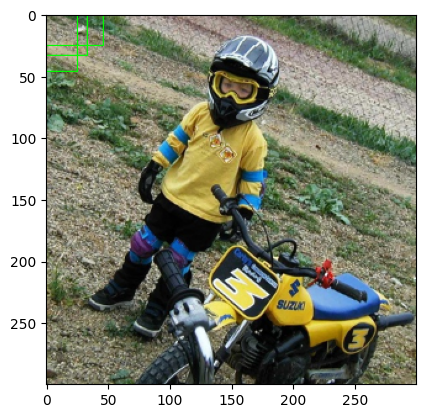

In [109]:
def display_anchors(img, fmap, sizes, ratios):
    # img: image to draw on
    # fmap: feature map
    # sizes: list of sizes of anchor boxes
    # ratios: list of aspect ratios of anchor boxes
    for i in range(fmap):
        for j in range(fmap):
            cx = (j + 0.5) / fmap
            cy = (i + 0.5) / fmap
            for s in sizes:
                for r in ratios:
                    w = s * np.sqrt(r)
                    h = s / np.sqrt(r)
                    x1 = cx - w / 2
                    y1 = cy - h / 2
                    x2 = cx + w / 2
                    y2 = cy + h / 2
                    print(x1, y1, x2, y2)
                    cv2.rectangle(
                        img,
                        (int(x1 * IMG_SIZE), int(y1 * IMG_SIZE)),
                        (int(x2 * IMG_SIZE), int(y2 * IMG_SIZE)),
                        (0, 255, 0),
                        1,
                    )
                return img

img_path = "dataset_final/images/2007_000733.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = display_anchors(img, 38, [0.2], [0.5, 1, 2])
plt.imshow(img)

# SSD

## Base model

In [110]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
basemodel = VGG16(
    include_top=False, weights="imagenet", input_tensor=inputs
)  # include_top=False means we don't want the last layer
basemodel.trainable = False

conv_4_3 = basemodel.get_layer("block4_conv3").output
conv_5_3 = basemodel.get_layer("block5_conv3").output
# 18x18
pool5 = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding="same")(conv_5_3)

model = Model(inputs=basemodel.input, outputs=pool5)
# model.summary()

## Auxiliary Convolutions

In [111]:
class L2Normalization(layers.Layer):
    def __init__(self, scale, **kwargs):
        self.scale = scale
        super(L2Normalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.scale = self.add_weight(
            name="scale",
            initializer=keras.initializers.Constant(self.scale),
            trainable=True,
        )
        super(L2Normalization, self).build(input_shape)

    def call(self, inputs):
        return self.scale * tf.math.l2_normalize(inputs, axis=-1)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'scale': self.scale,
        })
        return config
    
def block_conv_1x1(inputs, filters, name):
    conv = layers.Conv2D(
        filters, (1, 1), activation="relu", padding="same", kernel_regularizer=l2(L2_REG), name=name
    )(inputs)
    return conv

def block_conv_3x3(inputs, filters, name):
    conv = layers.Conv2D(
        filters, (3, 3), strides=(2, 2), activation="relu", padding="valid", kernel_regularizer=l2(L2_REG), name=name 
    )(inputs)
    return conv

In [112]:
# 37x37
conv_4_3 = L2Normalization(scale=20, name="conv_4_3")(conv_4_3)

# 18x18
conv_6 = layers.Conv2D(
    1024, (3, 3), activation="relu", padding="same", name="conv_6"
)(pool5)
conv_7 = layers.Conv2D(
    1024, (1, 1), activation="relu", padding="same", name="conv_7"
)(conv_6)

# 8x8
conv_8_1 = block_conv_1x1(conv_7, 256, "conv_8_1")
conv_8_2 = block_conv_3x3(conv_8_1, 512, "conv_8_2")

# 3x3
conv_9_1 = block_conv_1x1(conv_8_2, 128, "conv_9_1")
conv_9_2 = block_conv_3x3(conv_9_1, 256, "conv_9_2")

# 1x1
conv_10_1 = block_conv_1x1(conv_9_2, 128, "conv_10_1")
conv_10_2 = block_conv_3x3(conv_10_1, 256, "conv_10_2")

model = Model(inputs=inputs, outputs=[conv_4_3, conv_7, conv_8_2, conv_9_2, conv_10_2])
# model.summary()

## Prediction Convolutions

### Config

In [113]:
config = {
    "min_scale": 0.2,
    "max_scale": 0.9,
    "offset": 0.5,
    "variances": [0.1, 0.1, 0.2, 0.2],
    "iou_threshold": 0.5,
    "neg_pos_ratio": 3,
    "neutral_threshold": 0.3,
    "layers":[
        {"layer_name": "conv_4_3", "aspect_ratios": [1.0, 2.0, 0.5], "size": 37},
        {"layer_name": "conv_7", "aspect_ratios": [1.0, 2.0, 0.5, 3.0, 0.33], "size": 18},
        {"layer_name": "conv_8_2", "aspect_ratios": [1.0, 2.0, 0.5, 3.0, 0.33], "size": 8},
        {"layer_name": "conv_9_2", "aspect_ratios": [1.0, 2.0, 0.5], "size": 3},
        {"layer_name": "conv_10_2", "aspect_ratios": [1.0, 2.0, 0.5], "size": 1},
    ]
}

### Function, class support

In [114]:
def get_number_default_boxes(aspect_ratios):
    return len(aspect_ratios) + 1 if 1 in aspect_ratios else len(aspect_ratios)

def center_to_corner(center):
    x1 = center[..., 0] - center[..., 2] / 2
    y1 = center[..., 1] - center[..., 3] / 2
    x2 = center[..., 0] + center[..., 2] / 2
    y2 = center[..., 1] + center[..., 3] / 2
    return tf.stack([x1, y1, x2, y2], axis=-1)

def corner_to_center(corner):
    x = (corner[..., 0] + corner[..., 2]) / 2
    y = (corner[..., 1] + corner[..., 3]) / 2
    w = corner[..., 2] - corner[..., 0]
    h = corner[..., 3] - corner[..., 1]
    return tf.stack([x, y, w, h], axis=-1)

In [115]:
class DefaultBoxes(layers.Layer):
    def __init__(self, img_size, aspect_ratios, scale, next_scale, variances, **kwargs):
        self.img_size = img_size
        self.aspect_ratios = aspect_ratios
        self.scale = scale
        self.next_scale = next_scale
        self.variances = variances
        super(DefaultBoxes, self).__init__(**kwargs)

    def build(self, input_shape):
        _, f_map_h, f_map_w, _ = input_shape

        assert f_map_h == f_map_w, "Feature map must be square"
        self.f_map_size = f_map_h

        super(DefaultBoxes, self).build(input_shape)

    def call(self, inputs):
        grid_size = self.img_size / self.f_map_size
        num_default_boxes = get_number_default_boxes(self.aspect_ratios)
        # Generate w, h of default boxes
        wh_list = []
        for ar in self.aspect_ratios:
            if ar == 1:
                wh_list.append([
                    self.img_size * tf.math.sqrt(self.scale * self.next_scale) * tf.math.sqrt(ar),
                    self.img_size * tf.math.sqrt(self.scale * self.next_scale) / tf.math.sqrt(ar)
                ])
            wh_list.append([
                self.img_size * self.scale * tf.math.sqrt(ar),
                self.img_size * self.scale / tf.math.sqrt(ar)
            ])
        wh_list = tf.convert_to_tensor(wh_list, dtype=tf.float32)
        wh_list = tf.reshape(wh_list, [1, 1, num_default_boxes, 2])
        wh_list = tf.tile(wh_list, [self.f_map_size, self.f_map_size, 1, 1])

        # Generate centers of default boxes
        cx = tf.range(self.f_map_size, dtype=tf.float32) * grid_size + grid_size / 2
        cy = tf.range(self.f_map_size, dtype=tf.float32) * grid_size + grid_size / 2
        cx_grid, cy_grid = tf.meshgrid(cx, cy)
        cx_grid, cy_grid = tf.expand_dims(cx_grid, axis=-1), tf.expand_dims(cy_grid, axis=-1)
        cx_grid, cy_grid = tf.tile(cx_grid, [1, 1, num_default_boxes]), tf.tile(cy_grid, [1, 1, num_default_boxes])

        # Concatenate cx, cy, w, h
        default_boxes = tf.concat([cx_grid[..., tf.newaxis], cy_grid[..., tf.newaxis], wh_list], axis=-1)

        # Fix overflow default boxes 
        default_boxes = center_to_corner(default_boxes)
        default_boxes = tf.clip_by_value(default_boxes, 0, self.img_size)
        default_boxes = corner_to_center(default_boxes)

        # Norm
        default_boxes = default_boxes / self.img_size

        # Add variances
        variances_tensor = tf.convert_to_tensor(self.variances, dtype=tf.float32)
        variances_tensor = tf.reshape(variances_tensor, [1, 1, 1, 4])
        variances_tensor = tf.tile(variances_tensor, [self.f_map_size, self.f_map_size, num_default_boxes, 1])
        default_boxes = tf.concat([default_boxes, variances_tensor], axis=-1)

        # N input
        default_boxes = tf.expand_dims(default_boxes, axis=0)
        default_boxes = tf.tile(default_boxes, [tf.shape(inputs)[0], 1, 1, 1, 1])
        return default_boxes
    
    def get_config(self):
        config = super(DefaultBoxes, self).get_config()
        config.update({
            "img_size": self.img_size,
            "aspect_ratios": self.aspect_ratios,
            "scale": self.scale,
            "next_scale": self.next_scale,
        })
        return config


### Model

In [116]:
scales = tf.linspace(config["min_scale"], config["max_scale"], len(config["layers"]))

layers_conf = []
layers_loc = []
layers_default_boxes = []
for i in range(len(config["layers"])):
    config_layer = config["layers"][i]
    layer_name = config_layer["layer_name"]
    number_default_boxes = get_number_default_boxes(config_layer["aspect_ratios"])
    x = model.get_layer(layer_name).output

    layer_conf = layers.Conv2D(
        number_default_boxes * N_CLASSES,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=l2(L2_REG),
        name=layer_name + "_conf",
    )(x)
    # f_map_size * f_map_size * number_default_boxes x N_CLASSES
    layer_conf = layers.Reshape((-1, N_CLASSES))(layer_conf)

    layer_loc = layers.Conv2D(
        number_default_boxes * 4,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=l2(L2_REG),
        name=layer_name + "_loc",
    )(x)
    # f_map_size * f_map_size * number_default_boxes x 4
    layer_loc = layers.Reshape((-1, 4))(layer_loc)

    layer_default_boxes = DefaultBoxes(
        img_size=IMG_SIZE,
        aspect_ratios=config_layer["aspect_ratios"],
        scale=scales[i],
        next_scale=scales[i + 1] if i + 1 < len(scales) else 1.0,
        variances=config["variances"],
        name=layer_name + "_default_boxes",
    )(x)
    # f_map_size * f_map_size * number_default_boxes x 8
    layer_default_boxes = layers.Reshape((-1, 8))(layer_default_boxes)

    layers_conf.append(layer_conf)
    layers_loc.append(layer_loc)
    layers_default_boxes.append(layer_default_boxes)

output_conf = layers.Concatenate(axis=1, name="conf")(layers_conf)
output_conf = layers.Activation("softmax", name="conf_softmax")(output_conf)
output_loc = layers.Concatenate(axis=1, name="loc")(layers_loc)
output_default_boxes = layers.Concatenate(axis=1, name="default_boxes")(layers_default_boxes)
predictions = layers.Concatenate(axis=2, name="predictions")([output_conf, output_loc, output_default_boxes])

model = Model(inputs=model.input, outputs= predictions)
# model.summary()

## Loss

In [117]:
def smooth_L1(y_true, y_pred):
    absolute_value = tf.abs(y_true - y_pred)
    square = 0.5 * (y_true - y_pred) ** 2
    loss = tf.where(absolute_value < 1.0, square, absolute_value - 0.5)
    return tf.reduce_sum(loss, axis=-1)

In [118]:
class SSDLoss(keras.losses.Loss):
    def __init__(self, neg_pos_ratio=3, alpha=1.0, **kwargs):
        super(SSDLoss, self).__init__(**kwargs)
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

    def call(self, y_true, y_pred):
        # Split y_pred
        y_pred_conf = y_pred[:, :, :-12]
        y_pred_loc = y_pred[:, :, -12:-8]

        # Split y_true
        y_true_conf = y_true[:, :, :-12]
        y_true_loc = y_true[:, :, -12:-8]
        
        # Compute conf loss use cross entropy
        conf_loss = keras.losses.categorical_crossentropy(y_true_conf, y_pred_conf, from_logits=True)

        # Compute loc loss use smooth L1
        loc_loss = smooth_L1(y_true_loc, y_pred_loc)
        
        # Compute negative and positive loss
        negatives  = y_true_conf[:, :, 0]
        positives = tf.reduce_max(y_true_conf[:, :, 1:], axis=-1)
        num_positives = tf.reduce_sum(positives)

        # Compute negative conf loss
        negatives_conf_loss = conf_loss * negatives
        negatives_conf_loss = tf.reshape(negatives_conf_loss, [-1])
        num_negatives = tf.math.minimum(self.neg_pos_ratio * num_positives, tf.reduce_sum(negatives))
        _, indices = tf.nn.top_k(negatives_conf_loss, k=tf.cast(num_negatives, tf.int32))
        negatives_conf_loss = tf.gather(negatives_conf_loss, indices)
        negatives_conf_loss = tf.reduce_sum(negatives_conf_loss)

        # Compute positive conf loss
        positives_conf_loss = conf_loss * positives
        positives_conf_loss = tf.reduce_sum(positives_conf_loss)

        # Compute total conf loss
        total_conf_loss = positives_conf_loss + negatives_conf_loss

        # Compute positive loc loss
        positives_loc_loss = loc_loss * positives
        positives_loc_loss = tf.reduce_sum(positives_loc_loss)

        # Compute total loss
        total_loss = (total_conf_loss + self.alpha * positives_loc_loss) / num_positives
        return total_loss

    def get_config(self):
        config = super(SSDLoss, self).get_config()
        config.update({"neg_pos_ratio": self.neg_pos_ratio, "alpha": self.alpha})
        return config
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=SSDLoss())

## Data Generator

In [119]:
def compute_iou(boxes1, boxes2):
    # Intersection
    int_xmin = tf.math.maximum(boxes1[..., 0] - boxes1[..., 2] / 2, boxes2[..., 0] - boxes2[..., 2] / 2)
    int_ymin = tf.math.maximum(boxes1[..., 1] - boxes1[..., 3] / 2, boxes2[..., 1] - boxes2[..., 3] / 2)
    int_xmax = tf.math.minimum(boxes1[..., 0] + boxes1[..., 2] / 2, boxes2[..., 0] + boxes2[..., 2] / 2)
    int_ymax = tf.math.minimum(boxes1[..., 1] + boxes1[..., 3] / 2, boxes2[..., 1] + boxes2[..., 3] / 2)
    int_w = tf.math.maximum(int_xmax - int_xmin, 0)
    int_h = tf.math.maximum(int_ymax - int_ymin, 0)
    int_area = int_w * int_h

    # Union
    area1 = boxes1[..., 2] * boxes1[..., 3]
    area2 = boxes2[..., 2] * boxes2[..., 3]
    union_area = area1 + area2 - int_area

    return int_area / union_area

In [120]:
def read_xml(label_path):
    assert os.path.exists(label_path), "Label path does not exist"
    tree = ET.parse(label_path)
    root = tree.getroot()
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    objects = root.findall("object")
    bboxes = []
    class_names = []
    for object in objects:
        name = object.find("name").text
        bndbox = object.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        bboxes.append([xmin, ymin, xmax, ymax])
        class_names.append(name)
    return bboxes, class_names, width, height

def read_data(img_path, label_path):
    assert os.path.exists(img_path), "Image path does not exist"
    assert os.path.exists(label_path), "Label path does not exist"

    # Read image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Read label
    bboxes, classes, width, height = read_xml(label_path)
    bboxes = tf.constant(bboxes, dtype=tf.float32)
    bboxes = tf.stack(
        [
            bboxes[:, 0] / width,
            bboxes[:, 1] / height,
            bboxes[:, 2] / width,
            bboxes[:, 3] / height,
        ],
        axis=-1,
    )
    classes = tf.constant(classes, dtype=tf.string)
    
    return img, bboxes, classes


def one_hot_encode(class_name, labels_class):
    # check class_names in labels_class
    assert class_name in labels_class, "Class name does not exist in labels class"

    # one hot encode
    one_hot = tf.one_hot(labels_class.index(class_name), len(labels_class))
    return one_hot

def encode_bboxes(matched_bboxes, matched_default_boxes, variances):
    # Encode bbox
    cx = (matched_bboxes[..., 0] - matched_default_boxes[..., 0]) / matched_default_boxes[..., 2]
    cy = (matched_bboxes[..., 1] - matched_default_boxes[..., 1]) / matched_default_boxes[..., 3]
    w = tf.math.log(matched_bboxes[..., 2] / matched_default_boxes[..., 2])
    h = tf.math.log(matched_bboxes[..., 3] / matched_default_boxes[..., 3])
    encoded_bboxes = tf.stack([cx, cy, w, h], axis=-1)
    encoded_bboxes = encoded_bboxes / variances
    # Fix inf
    encoded_bboxes = tf.where(tf.math.is_inf(encoded_bboxes), tf.zeros_like(encoded_bboxes), encoded_bboxes)
    return matched_bboxes

In [121]:
"""
    - Each ground truth box is matched to the default box that has the highest IOU
    - The remaining default boxes are matched with ground truth boxes that has IOUs larger than a certain threshold, this allows a ground truth box to be matched with more than one default boxes
    - There will also be boxes that are neither background nor has enough IOU scores to qualify as a match, these boxes are called “neutral boxes”.

    Inputs: gt_boxes, default_boxes, iou_thre, neutral_thre
    gt_boxes: [xmin, ymin, xmax, ymax]
    default_boxes: [xmin, ymin, xmax, ymax]

    Returns: matched_boxes, neutral_boxes
    matched_boxes: [index_gt_boxes, index_default_boxes]
    neutral_boxes: [index_gt_boxes, index_default_boxes]

"""

def match_gtboxes_defaultboxes(gt_boxes, default_boxes, iou_thre, neutral_thre):
    default_boxes = center_to_corner(default_boxes)

    num_gt_boxes = tf.shape(gt_boxes)[0]
    num_default_boxes = tf.shape(default_boxes)[0]

    # Match ground truth to default box with highest iou
    gt_boxes = tf.tile(gt_boxes[:, tf.newaxis, :], [1, num_default_boxes, 1])
    default_boxes = tf.tile(default_boxes[tf.newaxis, :, :], [num_gt_boxes, 1, 1])
    ious = compute_iou(gt_boxes, default_boxes).numpy()
    matched_df_idx = tf.argmax(ious, axis=1, output_type=tf.int32)
    matched_gt_idx = tf.range(num_gt_boxes)
    matched_boxes = tf.stack([matched_gt_idx, matched_df_idx], axis=-1)

    # Match default boxes with ground truth boxes that has iou larger than a certain threshold
    ious[:, matched_df_idx] = 0
    matched_gt_idx = tf.argmax(ious, axis=0, output_type=tf.int32)
    matched_df_idx = tf.range(num_default_boxes)
    matched_ious = ious[matched_gt_idx, matched_df_idx]
    matched_df_idx = tf.boolean_mask(matched_df_idx, matched_ious >= iou_thre)
    matched_gt_idx = tf.boolean_mask(matched_gt_idx, matched_ious >= iou_thre)
    matched_boxes = tf.concat(
        [matched_boxes, tf.stack([matched_gt_idx, matched_df_idx], axis=-1)], axis=0
    )

    # Neutral boxes
    ious[:, matched_df_idx] = 0
    matched_gt_idx = tf.argmax(ious, axis=0, output_type=tf.int32)
    matched_df_idx = tf.range(num_default_boxes)
    matched_ious = ious[matched_gt_idx, matched_df_idx]
    matched_df_idx = tf.boolean_mask(matched_df_idx, matched_ious >= neutral_thre)
    matched_gt_idx = tf.boolean_mask(matched_gt_idx, matched_ious >= neutral_thre)
    neutral_boxes = tf.stack([matched_gt_idx, matched_df_idx], axis=-1)

    return matched_boxes, neutral_boxes


In [122]:
class SSD_Data_Generator(keras.utils.Sequence):
    def __init__(self, dataset, labels_class, config, iou_thre, neutral_thre, batch_size=32, img_size=300, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.config = config
        self.labels_class = ["background"] + labels_class
        self.num_classes = len(self.labels_class)
        self.iou_thre = iou_thre
        self.neutral_thre = neutral_thre
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataset) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch = [self.dataset[i] for i in indexes]
        return self.__data_generation(batch)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            # Set seed
            np.random.seed(SEED)
            np.random.shuffle(self.indexes)

    def __get_input_template(self):
        scales = tf.linspace(config["min_scale"], config["max_scale"], len(config["layers"]))
        confs = []
        locs = []
        default_boxes = []
        for i in range(len(config["layers"])):
            config_layer = config["layers"][i]
            number_default_boxes = get_number_default_boxes(config_layer["aspect_ratios"])
            # Shape: (1, size, size, number_default_boxes, 8)
            layer_default_boxes = DefaultBoxes(
                img_size=self.img_size,
                scale=scales[i],
                next_scale=scales[i + 1] if i + 1 < len(scales) else 1.0,
                aspect_ratios=config_layer["aspect_ratios"],
                variances=config["variances"],
            )(tf.zeros((1, config_layer["size"], config_layer["size"], 3)))
            layer_default_boxes = tf.reshape(
                layer_default_boxes, (1, -1, 8)
            )
            confs.append(tf.zeros((1, config_layer["size"] ** 2 * number_default_boxes, self.num_classes)))
            locs.append(tf.zeros((1, config_layer["size"] ** 2 * number_default_boxes, 4)))
            default_boxes.append(layer_default_boxes)
        
        confs = tf.concat(confs, axis=1)
        # Set all default boxes to background
        confs = tf.one_hot(0, self.num_classes, dtype=tf.float32) * tf.ones_like(confs)
        locs = tf.concat(locs, axis=1)
        default_boxes = tf.concat(default_boxes, axis=1)
        template = tf.concat([confs, locs, default_boxes], axis=-1)
        template = tf.tile(template, (self.batch_size, 1, 1))
        return template
            
    def __data_generation(self, batch):
        images = []
        labels = self.__get_input_template().numpy()
        for batch_idx, (image_path, label_path) in enumerate(batch):
            img, bboxes, class_names = read_data(image_path, label_path)
            
            # Resize image
            img = tf.image.resize(img, (self.img_size, self.img_size))
            images.append(img)

            # One hot encode class names
            class_names = [one_hot_encode(name, self.labels_class) for name in class_names]
            class_names = tf.convert_to_tensor(class_names, dtype=tf.float32)
            
            # Match ground truth boxes to default boxes
            matched_boxes, neutral_boxes = match_gtboxes_defaultboxes(
                bboxes, labels[batch_idx, :, -8:-4], self.iou_thre, self.neutral_thre
            )

            # Set matched boxes to ground truth boxes
            labels[batch_idx, matched_boxes[:, 1], 0] = 0
            labels[batch_idx, matched_boxes[:, 1], :self.num_classes] = tf.gather(class_names, matched_boxes[:, 0])
            labels[batch_idx, matched_boxes[:, 1], self.num_classes:self.num_classes + 4] = tf.gather(bboxes, matched_boxes[:, 0])

            # Neutral boxes have a class vector of all zeros
            labels[batch_idx, neutral_boxes[:, 1], :self.num_classes] = 0
            labels[batch_idx, neutral_boxes[:, 1], self.num_classes:self.num_classes + 4] = tf.gather(bboxes, neutral_boxes[:, 0])

            # Encode ground truth boxes
            labels[batch_idx, :, self.num_classes:self.num_classes + 4] = encode_bboxes(
                labels[batch_idx, :, self.num_classes:self.num_classes + 4],
                labels[batch_idx, :, -8:-4],
                labels[batch_idx, :, -4:],
            )
            
        images = tf.stack(images, axis=0)
        
        return images, labels

## Decode predict SSD

In [123]:
def decode_bbox(loc, default_box):
    cx = loc[..., 0] * default_box[..., 2] * default_box[..., 4] + default_box[..., 0]
    cy = loc[..., 1] * default_box[..., 3] * default_box[..., 5] + default_box[..., 1]
    w = tf.exp(loc[..., 2] * default_box[..., 6]) * default_box[..., 2]
    h = tf.exp(loc[..., 3] * default_box[..., 7]) * default_box[..., 3]
    return tf.stack([cx, cy, w, h], axis=-1)

In [124]:
class DecodePredictSSD(layers.Layer):
    def __init__(self, img_size, nms_max_output_size=400, conf_thre=0.5, iou_thre=0.45, num_pred=10, **kwargs):
        super(DecodePredictSSD, self).__init__(**kwargs)
        self.img_size = img_size
        self.nms_max_output_size = nms_max_output_size
        self.conf_thre = conf_thre
        self.iou_thre = iou_thre
        self.num_pred = num_pred

    # returns: (batch_size, num_pred, 6)
    # 6: [class_id, conf, x1, y1, x2, y2]
    def call(self, inputs):
        confs = inputs[..., :-12]
        locs = inputs[..., -12:-8]
        default_boxes = inputs[..., -8:]

        # Decode bounding boxes
        bboxs = decode_bbox(locs, default_boxes)
        bboxs = center_to_corner(bboxs)
        bboxs = tf.clip_by_value(bboxs, 0, 1)
        bboxs = bboxs * self.img_size

        num_classes = tf.shape(confs)[2]
        class_indices = tf.range(1, num_classes)
        confs = tf.gather(confs, class_indices, axis=-1)

        y_pred = tf.concat([confs, bboxs], axis=-1)

        # (batch_size, num_pred, 6)
        output = tf.map_fn(
            lambda x: self.filter_predictions(x, tf.range(0, num_classes-1)),
            y_pred,
            dtype=tf.float32,
        )

        return output

        

    def filter_predictions(self, y_pred, class_indices):
        output = tf.map_fn(
            lambda x: self.filter_single_class(y_pred, x),
            class_indices,
            dtype=tf.float32,
        )
        output = tf.reshape(output, (-1, 6))
        output = tf.gather(
            output, tf.argsort(output[:, 1], direction="DESCENDING"), axis=0
        )
        output = output[: self.num_pred]
        return output

        

    def filter_single_class(self, y_pred, index):
        # y_pred: (num_default_boxes, num_classes + 4)
        # index: int
        confs = y_pred[:, index]
        bboxs = y_pred[:, -4:]
        class_id = tf.ones_like(confs) * float(index)
        class_id = tf.cast(class_id, dtype=tf.float32)

        # (num_default_boxes, 6)
        output = tf.concat([class_id[:, tf.newaxis], confs[:, tf.newaxis], bboxs], axis=-1)
        
        # Apply confidence threshold
        output = tf.boolean_mask(output, output[:, 1] > self.conf_thre)

        if tf.size(output) == 0:
            tf.zeros((self.num_pred, 6))

        else:
            # Apply NMS
            indices = tf.image.non_max_suppression(
                output[:, 2:],
                output[:, 1],
                self.nms_max_output_size,
                self.iou_thre,
            )
            output = tf.gather(output, indices)
        
        # Pad predictions
        output = tf.pad(output, ((0, self.nms_max_output_size - tf.shape(output)[0]), (0, 0)))

        return output
        

## Test SSD

In [157]:
labels_class = ["bicycle", "bus", "car", "motorbike", "person", "trafficsignal", "trafficlight"]

dataset = pd.read_csv("data/data.csv")
dataset = dataset.to_numpy()
dataset = dataset[:1000]
# Create data generator
data_generator = SSD_Data_Generator(
    dataset,
    labels_class,
    config,
    iou_thre=0.7,
    neutral_thre=0.7,
    batch_size=32,
    img_size=300,
    shuffle=True,
)
# Get a batch
images, labels = data_generator[0]
images = images.numpy()

In [158]:
model = Model(inputs, predictions)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=SSDLoss())
model.fit(data_generator, epochs=5)

Epoch 1/5
31/31 [==============================] - 105s 3s/step - loss: 8.3320
Epoch 2/5
31/31 [==============================] - 93s 3s/step - loss: 7.8926
Epoch 3/5
31/31 [==============================] - 93s 3s/step - loss: 6.2270
Epoch 4/5
31/31 [==============================] - 94s 3s/step - loss: 6.0064
Epoch 5/5
31/31 [==============================] - 93s 3s/step - loss: 5.9762


1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


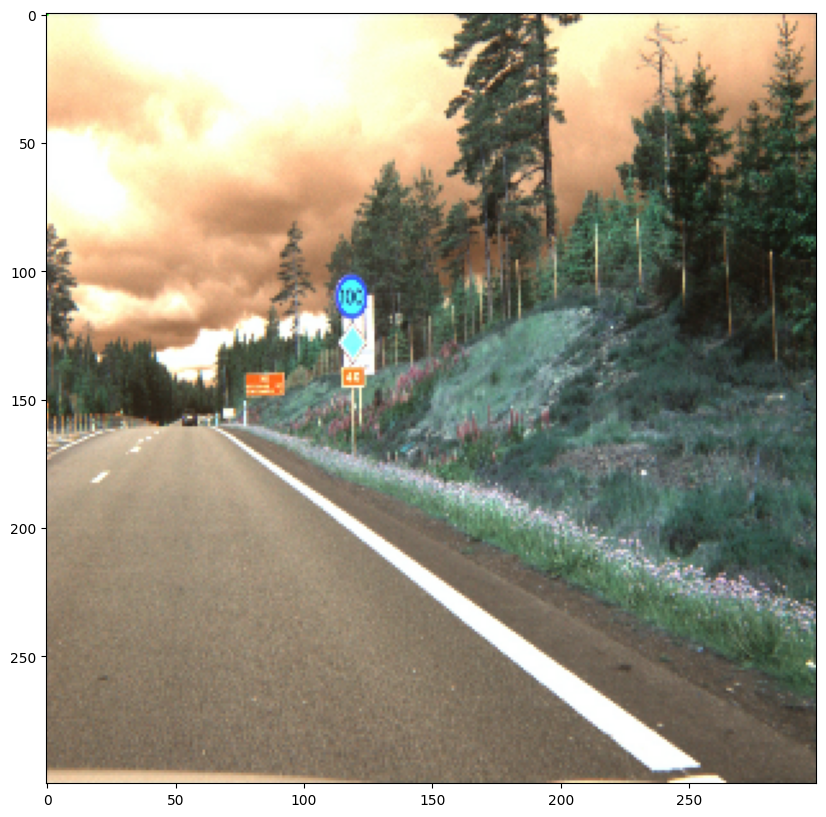

In [165]:
index = 10

y_pred = model.predict(tf.expand_dims(images[index], axis=0))

#Decode predictions
decode_predict = DecodePredictSSD(img_size=300, num_pred=10,conf_thre=0.1, iou_thre=0.45)
y_pred = decode_predict(y_pred)

def display_result(img, y_pred):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for i in range(y_pred.shape[0]):
        if y_pred[i, 1] == -1:
            break
        x1 = int(y_pred[i, 2])
        y1 = int(y_pred[i, 3])
        x2 = int(y_pred[i, 4])
        y2 = int(y_pred[i, 5])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.putText(
            img,
            labels_class[int(y_pred[i, 0])],
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
        )
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

display_result(images[index], y_pred[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


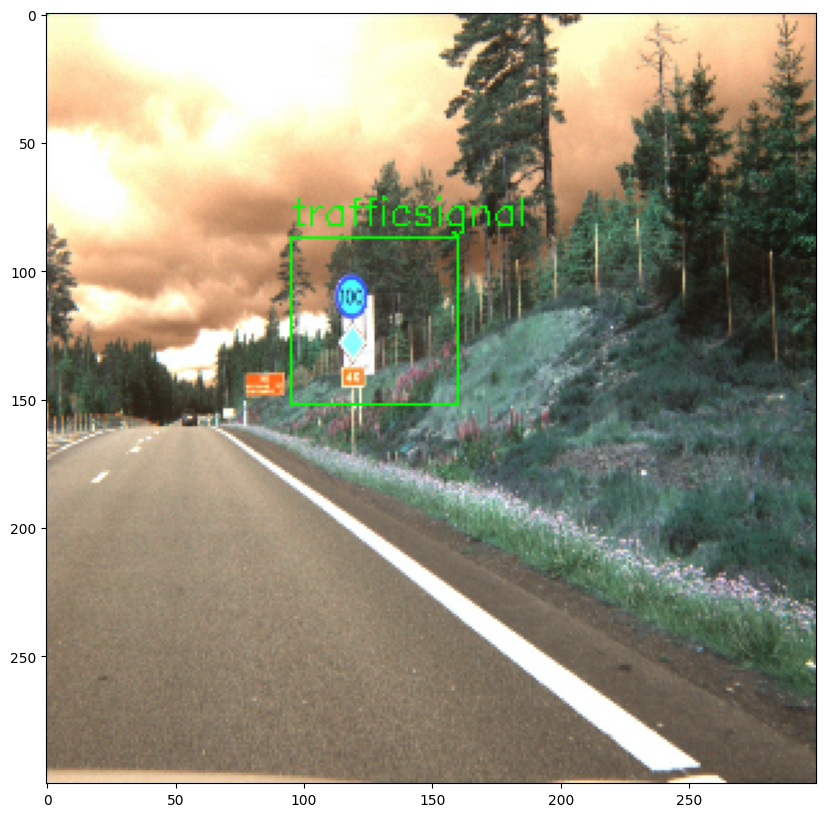

In [168]:
y_pred = decode_predict(tf.expand_dims(labels[10], axis=0))
display_result(images[10], y_pred[0])

In [130]:
x = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.ones_like(x) * 2

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 2, 2],
       [2, 2, 2]])>